In [10]:
import pandas as pd
import os
import requests
import elapid as ela
import rasterio
from rasterio.mask import mask
from rasterio.plot import show
from rasterio.windows import from_bounds
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

mpl.style.use("ggplot")

### Load kikuyugrass observations (y=1)

In [2]:
data = pd.read_csv("./inaturalist_observations_cleaned.csv")
data[["lat", "long"]] = data["location"].str.split(",", expand=True)
data["lat"] = data["lat"].astype(float)
data["long"] = data["long"].astype(float)

location_data = data[["lat", "long", "uuid"]]
location_data = pd.DataFrame(location_data)
location_data.head()

,lat,long,uuid
0,34.041287,-118.532091,cf6f9a84-0996-4ded-b2e0-a7bd12d67217
1,32.658961,-117.060481,39f544ee-5509-49ea-a296-19c825217ee1
2,35.322144,-120.823204,28751c0a-3cd3-4f64-9058-75e564f328f8
3,37.831630,-122.534875,03159809-00bc-4852-bbd6-2aab8038a6ba
4,32.737291,-117.126908,192ed8dc-5066-42cb-b58f-8cf69f070b2a


### Convert lat long to geoseries and plot

In [3]:
geometry = ela.xy_to_geoseries(x=location_data["long"], y=location_data["lat"])

# Merge into gdf
data_gdf = gpd.GeoDataFrame(data[["uuid"]], geometry=geometry)
data_gdf.head()

,uuid,geometry
0,cf6f9a84-0996-4ded-b2e0-a7bd12d67217,POINT (-118.53209 34.04129)
1,39f544ee-5509-49ea-a296-19c825217ee1,POINT (-117.06048 32.65896)
2,28751c0a-3cd3-4f64-9058-75e564f328f8,POINT (-120.8232 35.32214)
3,03159809-00bc-4852-bbd6-2aab8038a6ba,POINT (-122.53488 37.83163)
4,192ed8dc-5066-42cb-b58f-8cf69f070b2a,POINT (-117.12691 32.73729)


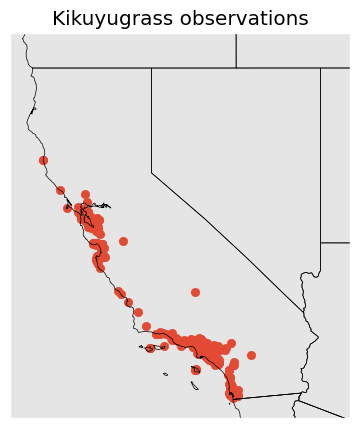

In [5]:
ca_extent = [-125, -113, 32, 43]

fig, ax = plt.subplots(figsize=(5, 5), subplot_kw={"projection": ccrs.PlateCarree()})
data_gdf.plot(ax=ax, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.BORDERS.with_scale("10m"), edgecolor="black")
ax.add_feature(cfeature.STATES.with_scale("10m"), edgecolor="black")
ax.set_extent(ca_extent, crs=ccrs.PlateCarree())
ax.set_title("Kikuyugrass observations")
plt.show()

### Check for any duplicate geometries

In [8]:
duplicates = data_gdf[data_gdf.duplicated(subset=["geometry"], keep=False)]
print("Duplicate geometries:")
print(duplicates)

Duplicate geometries:
Empty GeoDataFrame
Columns: [uuid, geometry]
Index: []


### Clip one of the global climate rasters to CA

In [ ]:
with open("./envidatS3paths.txt", "r") as file:
    urls = file.readlines()

for url in urls:
    url = url.strip()
    filename = os.path.basename(url)

    if "CHELSA_bio1_1981-2010_V.2.1.tif" in filename:
        save_path = os.path.join("./climate_data/", filename)
        print(f"Downloading {url} to {save_path}")

        response = requests.get(url)
        if response.status_code == 200:
            with open(save_path, "wb") as f:
                f.write(response.content)
            print(f"Downloaded {save_path}")
            break

Downloaded ./climate_data/CHELSA_bio1_1981-2010_V.2.1.tif


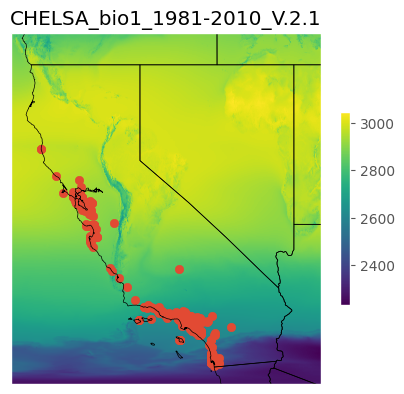

In [18]:
with rasterio.open("./climate_data/CHELSA_bio1_1981-2010_V.2.1.tif") as dataset:
    transform = dataset.transform
    window = from_bounds(*ca_extent, transform=transform)
    band1 = dataset.read(1, window=window)
    img_extent = (
        ca_extent[0],
        ca_extent[2],
        ca_extent[1],
        ca_extent[3],
    )

fig, ax = plt.subplots(figsize=(5, 5), subplot_kw={"projection": ccrs.PlateCarree()})
img = ax.imshow(
    band1,
    cmap="viridis",
    extent=[img_extent[0], img_extent[2], img_extent[1], img_extent[3]],
    origin="upper",
)
ax.add_feature(cfeature.STATES.with_scale("10m"), edgecolor="black")
data_gdf.plot(ax=ax, transform=ccrs.PlateCarree())
cbar = plt.colorbar(img, ax=ax, shrink=0.5)
ax.set_title("CHELSA_bio1_1981-2010_V.2.1")
plt.show()

   STATEFP   STATENS     AFFGEOID GEOID STUSPS        NAME LSAD         ALAND  \
12      06  01779778  0400000US06    06     CA  California   00  403503931312   

         AWATER                                           geometry  
12  20463871877  MULTIPOLYGON (((-118.59397 33.4672, -118.48478...  


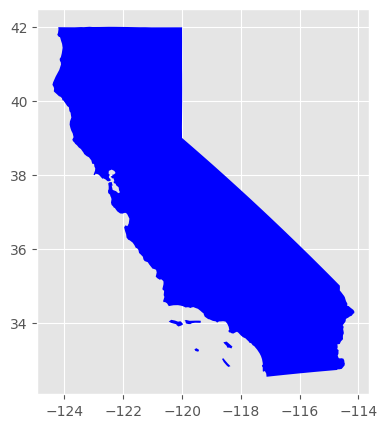

In [19]:
# Mask raster to CA boundary so we don't generate background points outside
url = "https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_state_20m.zip"
us_states = gpd.read_file(url)
california = us_states[us_states["NAME"] == "California"]
print(california)

fig, ax = plt.subplots(figsize=(5, 5))
california.plot(ax=ax, color="blue")
plt.show()

In [21]:
# Clip one of the climate rasters to the state boundary, to use the raster for background points
with rasterio.open("./climate_data/CHELSA_bio1_1981-2010_V.2.1.tif") as src:
    california = california.to_crs(src.crs)
    geoms = california.geometry.values
    out_image, out_transform = mask(src, geoms, crop=True, nodata=-9999)
    out_meta = src.meta
out_meta.update(
    {
        "driver": "GTiff",
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform,
        "dtype": "int16",
        "nodata": -9999,
    }
)

# save clipped raster
with rasterio.open("./california_clipped.tif", "w", **out_meta) as dest:
    dest.write(out_image)

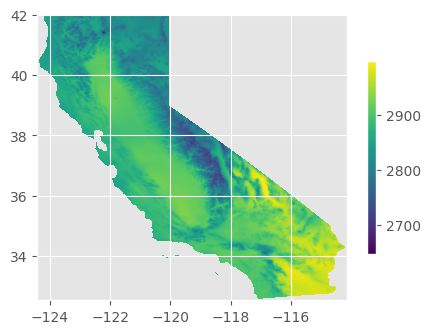

{'driver': 'GTiff', 'dtype': 'int16', 'nodata': -9999.0, 'width': 1234, 'height': 1138, 'count': 1, 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'), 'transform': Affine(0.0083333333, 0.0, -124.41680577785002,
       0.0, -0.0083333333, 42.016527249750006), 'blockxsize': 1234, 'blockysize': 3, 'tiled': False, 'interleave': 'band'}


In [23]:
with rasterio.open("./california_clipped.tif") as src:
    fig, ax = plt.subplots(figsize=(5, 5))
    image = show(src, ax=ax)
    cbar = plt.colorbar(image.get_images()[0], ax=ax, shrink=0.5)
    plt.show()
    print(src.profile)

### Generate background points

In [24]:
# Sample background points
background = ela.sample_raster(
    "./california_clipped.tif", count=10_000, ignore_mask=False
)

count                                          9910
unique                                         9910
top       POINT (-119.89597246260001 34.4290272801)
freq                                              1
dtype: object

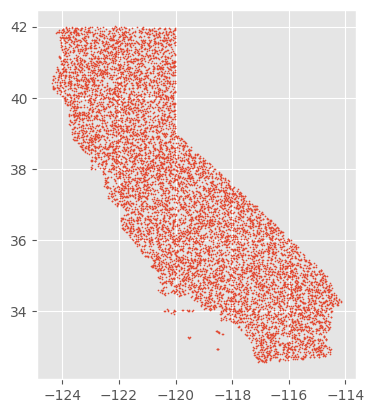

In [25]:
background.plot(markersize=0.5)
background.drop_duplicates(inplace=True)
background.describe()

### Save background points

In [27]:
gdf = gpd.GeoDataFrame(geometry=background)
gdf["lat"] = gdf.geometry.y
gdf["long"] = gdf.geometry.x
gdf["id"] = range(len(gdf))
gdf["label"] = "background"
gdf.head()

,geometry,lat,long,id,label
0,POINT (-119.89597 34.42903),34.429027,-119.895972,0,background
1,POINT (-115.84597 34.15403),34.154027,-115.845972,1,background
2,POINT (-121.84597 36.60403),36.604027,-121.845972,2,background
3,POINT (-122.08764 39.48736),39.487361,-122.087639,3,background
4,POINT (-119.67097 34.61236),34.612361,-119.670972,4,background


In [28]:
backgound_coords = gdf[["id", "label", "lat", "long"]]
backgound_coords.to_csv("./background_data_coords.csv", index=False)